In [46]:
from sklearn.cluster import KMeans 
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import RandomizedSearchCV

In [41]:
df = pd.read_csv("ks-projects-201801.csv", index_col="ID")

# 前処理

In [42]:
df = df.drop(columns=['pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'goal'])

# 日時に関する変数を TimeStamp に変換
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])
# 期間の変数を作成
df['period'] = (df['deadline'] - df['launched']).dt.days

# 異常値の削除
df = df[df['period'] < 10000] # 異常値の除去
# 欠損値の削除
df = df.dropna(axis=0)

# 目的変数の調整
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

df['n_words'] = df['name'].apply(lambda x: len(str(x).split(' ')))


# log
epsilon = 1e-5 # 対数変換の際に負の無限大に発散しないようにフロアリングするパラメータ
df['log_usd_goal'] = df['usd_goal_real'].apply(lambda x: np.log10(x + epsilon))

df = df.drop(columns=['name', 'deadline', 'launched', 'country','category','usd_goal_real'])

# 標準化
stdsc = StandardScaler()
df["period"] = stdsc.fit_transform(df[["period"]].values)

stdsc = StandardScaler()
df["n_words"] = stdsc.fit_transform(df[["n_words"]].values)

# 説明変数と目的変数の設定
X = df.drop(["state"], axis=1)
df["state"] = [1 if s == "successful" else 0 for s in df["state"]]
y = df["state"]

X = pd.get_dummies(X, drop_first=True)

# K-means

Text(0, 0.5, 'log_usd_goal')

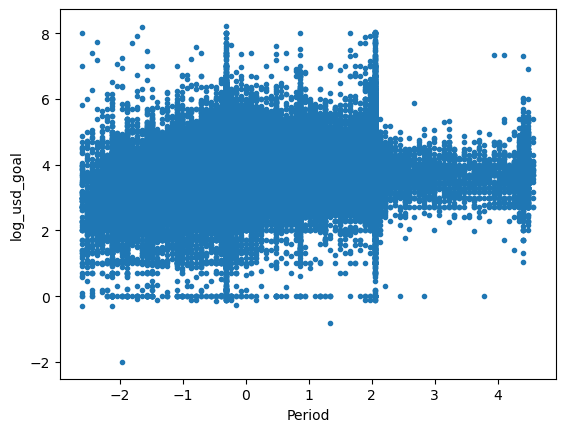

In [29]:
plt.scatter(df["period"],X["log_usd_goal"],marker='.')
plt.xlabel("Period")
plt.ylabel("log_usd_goal")

Text(0, 0.5, 'log_usd_goal')

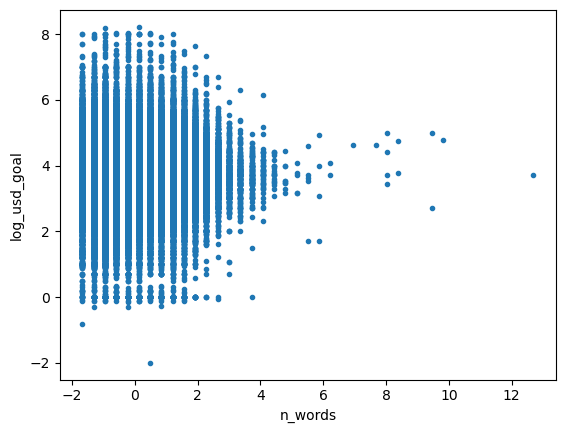

In [30]:
plt.scatter(df["n_words"],X["log_usd_goal"],marker='.')
plt.xlabel("n_words")
plt.ylabel("log_usd_goal")

Text(0, 0.5, 'n_words')

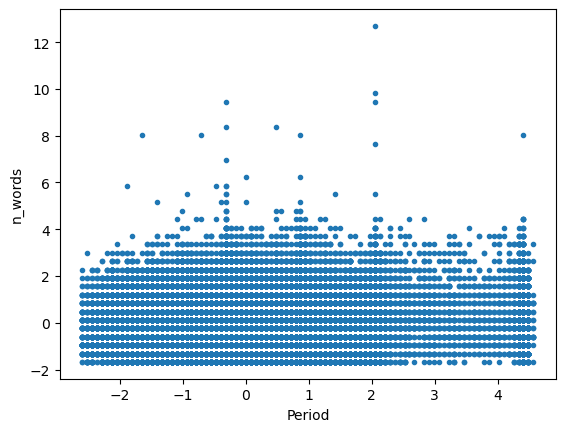

In [31]:
plt.scatter(df["period"],X["n_words"],marker='.')
plt.xlabel("Period")
plt.ylabel("n_words")

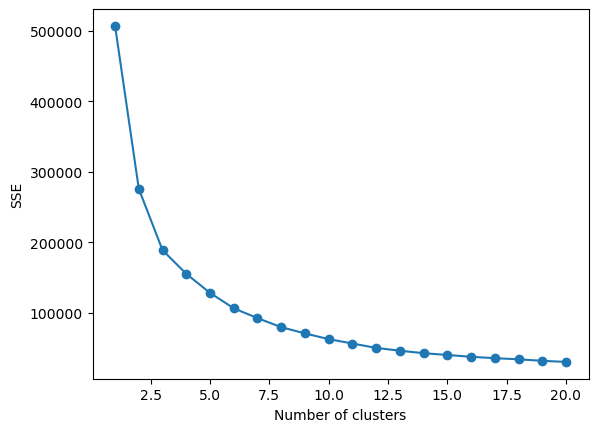

In [32]:
X_k = df[["period","log_usd_goal"]]

def plot_elbow(X, sta_k, end_k):
    sse = []
    for i in range(sta_k, end_k+1):
        clf = KMeans(n_clusters=i,random_state=1234)
        clf.fit(X)
        sse.append(clf.inertia_)

    plt.plot(range(sta_k, end_k+1), sse, marker="o")
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()
    
plot_elbow(X_k, 1, 20)

/var/folders/_0/2_dvy_6971dfbf9qw0p9q7lm0000gn/T/ipykernel_3864/3525416815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_k["label_pred"] = y_pred


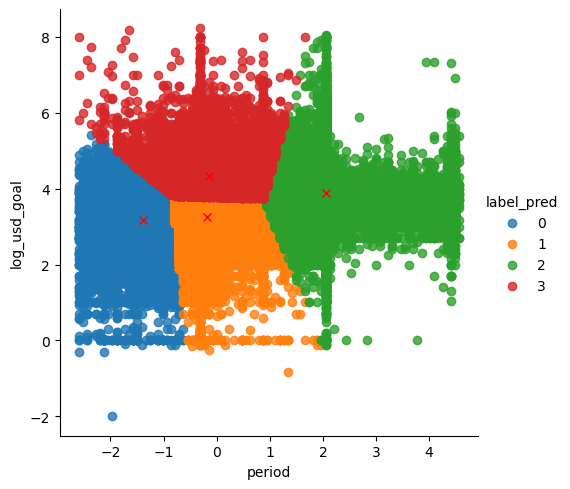

In [36]:
X_k = df[["period","log_usd_goal"]]

clf = KMeans(n_clusters=4)
clf.fit(X_k)
y_pred = clf.predict(X_k)

X_k["label_pred"] = y_pred
sns.lmplot(x="period", y="log_usd_goal", hue="label_pred", data=X_k,fit_reg=False)
plt.plot(clf.cluster_centers_[:,0],clf.cluster_centers_[:,1], marker="x",ls="",color="r")

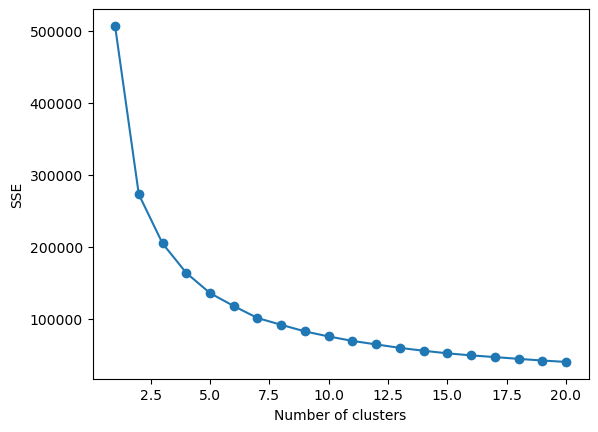

In [38]:
X_k = df[["n_words","log_usd_goal"]]

def plot_elbow(X, sta_k, end_k):
    sse = []
    for i in range(sta_k, end_k+1):
        clf = KMeans(n_clusters=i,random_state=1234)
        clf.fit(X)
        sse.append(clf.inertia_)

    plt.plot(range(sta_k, end_k+1), sse, marker="o")
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()
    
plot_elbow(X_k, 1, 20)

/var/folders/_0/2_dvy_6971dfbf9qw0p9q7lm0000gn/T/ipykernel_3864/1670407252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_k["label_pred"] = y_pred


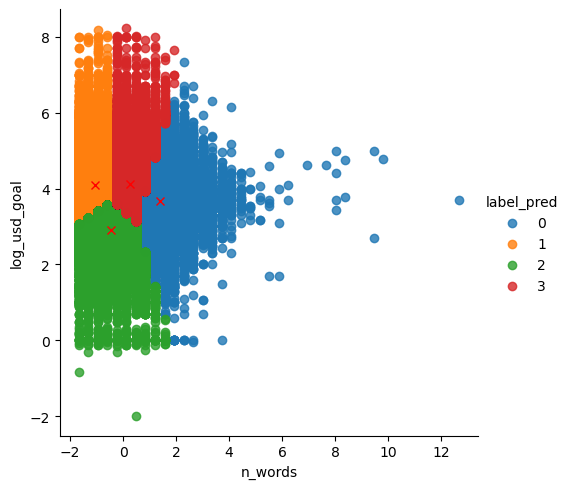

In [39]:
clf = KMeans(n_clusters=4)
clf.fit(X_k)
y_pred = clf.predict(X_k)

X_k["label_pred"] = y_pred
sns.lmplot(x="n_words", y="log_usd_goal", hue="label_pred", data=X_k,fit_reg=False)
plt.plot(clf.cluster_centers_[:,0],clf.cluster_centers_[:,1], marker="x",ls="",color="r")

# ハイパーパラメータチューニング

## ランダムサーチ

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [49]:
param = {
    "n_estimators":[10,50,100,200], 
    "max_depth":[5,10,20,100], 
    "criterion":["gini","entropy", "log_loss"],
    "min_samples_leaf":[2,5,10,20], 
    "min_samples_split":[1,2,3,4,5],
}

rscv = RandomizedSearchCV(RandomForestClassifier(), param, cv=5)

rscv.fit(X_train, y_train)

b_estimator = rscv.best_estimator_

/Users/chibakeigo/miniforge3/envs/suai/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/chibakeigo/miniforge3/envs/suai/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/chibakeigo/miniforge3/envs/suai/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/Users/chibakeigo/miniforge3/envs/suai/lib/python3.9/site-packages/joblib/parallel.py", line 1085, in __call__
 

In [50]:
print(b_estimator)

RandomForestClassifier(criterion='log_loss', max_depth=20, min_samples_leaf=5,
                       n_estimators=200)


In [52]:
clf = RandomForestClassifier(criterion='log_loss', max_depth=20, min_samples_leaf=5,
                       n_estimators=200,random_state=1234)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.669
Precision: 0.621
Recall: 0.461
F1: 0.529


## Day3でのランダムフォレストの結果
正解率: 0.657  
Precision: 0.638  
Recall: 0.348  
F1: 0.45  

全体的に精度は**向上している**